In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Changes-----------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
# Changes-----------------------------------
import tensorflow as tf
%matplotlib inline

2023-12-02 10:33:48.317664: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 10:33:51.263657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 10:33:51.263832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 10:33:51.474709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-02 10:33:52.020367: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
 
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 1000 # number of epochs
ALPHA = 0.1 # learning rate

BATCH_SIZE = 32 # other sizes leave last batch partial

TEST_SIZE = 0.2 # to create 64 batches of 256 rows each

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'large',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

In [5]:
text = open(os.path.join(inpDir, 'shakespeare.txt'))


In [6]:
data_df['datetime']= pd.to_datetime(data_df['Formatted Date'])
data_df=data_df.rename({'Temperature (C)':'temp'}, axis=1)

NameError: name 'data_df' is not defined

In [ ]:
temp = data_df[['datetime','temp']]
temp = temp.sort_values('datetime', axis=0)
temp = temp.reset_index(drop=True)
temp.head()

,datetime,temp
0,2006-01-01 00:00:00+01:00,0.577778
1,2006-01-01 01:00:00+01:00,1.161111
2,2006-01-01 02:00:00+01:00,1.666667
3,2006-01-01 03:00:00+01:00,1.711111
4,2006-01-01 04:00:00+01:00,1.183333


In [ ]:
temp.shape

(96453, 2)

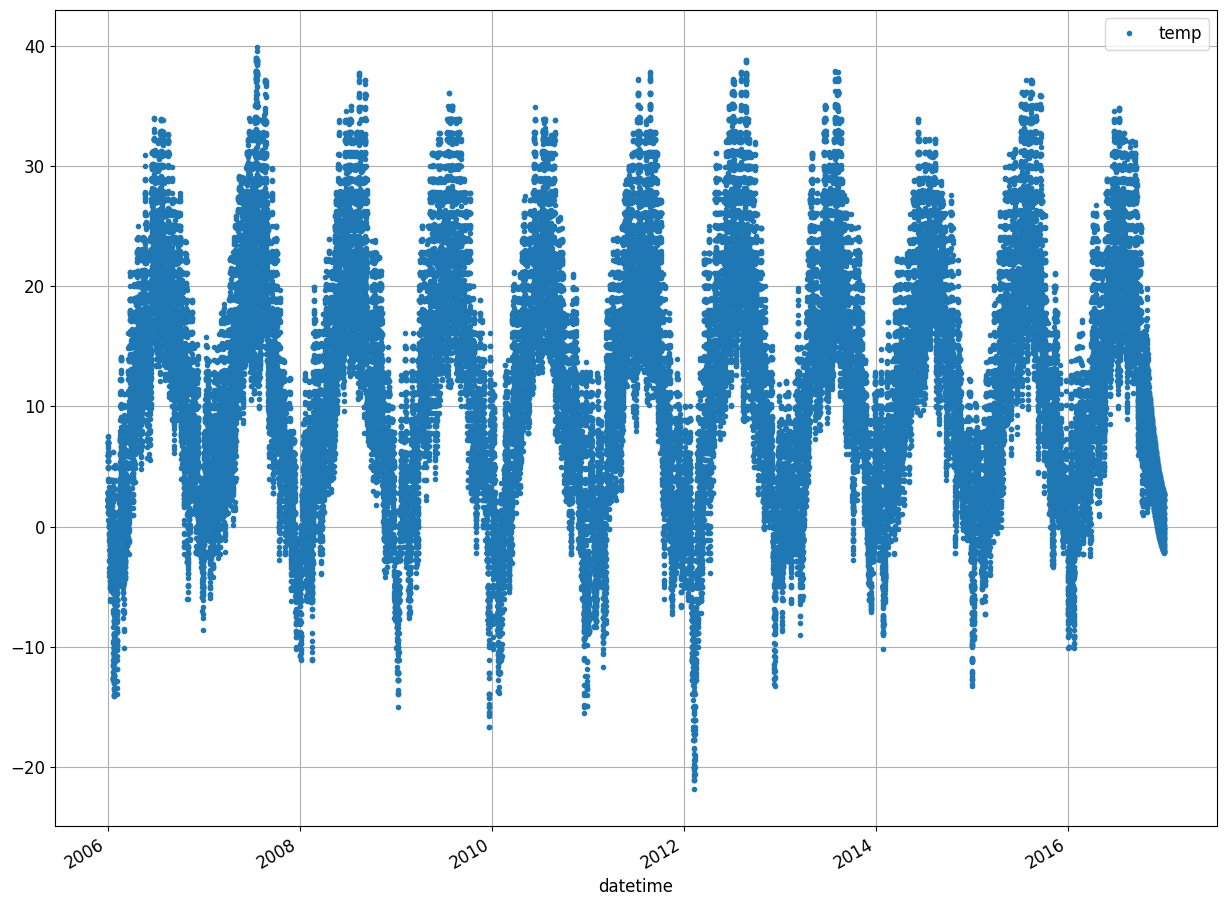

In [ ]:
fig, ax = plt.subplots(figsize = (15,12))
temp.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()

In [ ]:
time_step=24  ## Hourly data has been given

In [ ]:
y_idx = np.arange(time_step, temp.shape[0], time_step)
y_df = temp.iloc[y_idx]
y_df.head()

## we are taking every 24th data to make hourly data be divided into daywise form

,datetime,temp
24,2006-01-02 00:00:00+01:00,5.422222
48,2006-01-03 00:00:00+01:00,1.694444
72,2006-01-04 00:00:00+01:00,2.200000
96,2006-01-05 00:00:00+01:00,1.666667
120,2006-01-06 00:00:00+01:00,1.805556


In [ ]:
y_idx             ## divide the data into 24 hours 

array([   24,    48,    72, ..., 96384, 96408, 96432])

In [ ]:
X_df = temp.iloc[range(len(y_df) * time_step)]  
X_df.head(10)

,datetime,temp
0,2006-01-01 00:00:00+01:00,0.577778
1,2006-01-01 01:00:00+01:00,1.161111
2,2006-01-01 02:00:00+01:00,1.666667
3,2006-01-01 03:00:00+01:00,1.711111
4,2006-01-01 04:00:00+01:00,1.183333
5,2006-01-01 05:00:00+01:00,1.205556
6,2006-01-01 06:00:00+01:00,2.222222
7,2006-01-01 07:00:00+01:00,2.072222
8,2006-01-01 08:00:00+01:00,2.200000
9,2006-01-01 09:00:00+01:00,2.733333


In [ ]:
X_df['temp'].values.shape

(96432,)

In [ ]:
X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))  ##store entire days temp (hourly temp) in one column
X.shape

(4018, 24)

In [ ]:
X = X[:, :23]
X.shape

(4018, 23)

In [ ]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape

(4018, 23, 1)

spilt

In [ ]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [ ]:
h_units = 64
input_shape=(time_step-1, 1 ) # we are using one feature only.

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(units = h_units, 
                                    input_shape = input_shape, 
                                    activation = 'sigmoid'))

model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_fit= model.fit(X_train, y_train,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    batch_size= BATCH_SIZE, 
                    verbose=1)

Epoch 1/100
101/101 [==============================] - 2s 13ms/step - loss: 71.7693 - root_mean_squared_error: 8.4717 - val_loss: 23.2433 - val_root_mean_squared_error: 4.8211
Epoch 2/100
101/101 [==============================] - 1s 11ms/step - loss: 21.7992 - root_mean_squared_error: 4.6690 - val_loss: 8.3371 - val_root_mean_squared_error: 2.8874
Epoch 3/100
101/101 [==============================] - 1s 11ms/step - loss: 10.1527 - root_mean_squared_error: 3.1863 - val_loss: 4.0881 - val_root_mean_squared_error: 2.0219
Epoch 4/100
101/101 [==============================] - 1s 11ms/step - loss: 5.9867 - root_mean_squared_error: 2.4468 - val_loss: 2.4113 - val_root_mean_squared_error: 1.5528
Epoch 5/100
101/101 [==============================] - 1s 11ms/step - loss: 4.1063 - root_mean_squared_error: 2.0264 - val_loss: 1.7289 - val_root_mean_squared_error: 1.3149
Epoch 6/100
101/101 [==============================] - 1s 11ms/step - loss: 3.1492 - root_mean_squared_error: 1.7746 - val_los

In [ ]:
history_df = pd.DataFrame(model_fit.history)
history_df

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,71.769310,8.471677,23.243349,4.821136
1,21.799212,4.668962,8.337128,2.887408
2,10.152732,3.186335,4.088113,2.021908
3,5.986741,2.446782,2.411336,1.552848
4,4.106301,2.026401,1.728916,1.314883
...,...,...,...,...
95,0.978733,0.989309,0.649975,0.806210
96,0.967018,0.983371,0.642979,0.801860
97,0.975023,0.987433,0.635713,0.797316
98,0.977044,0.988455,0.679750,0.824470
